Populating the interactive namespace from numpy and matplotlib


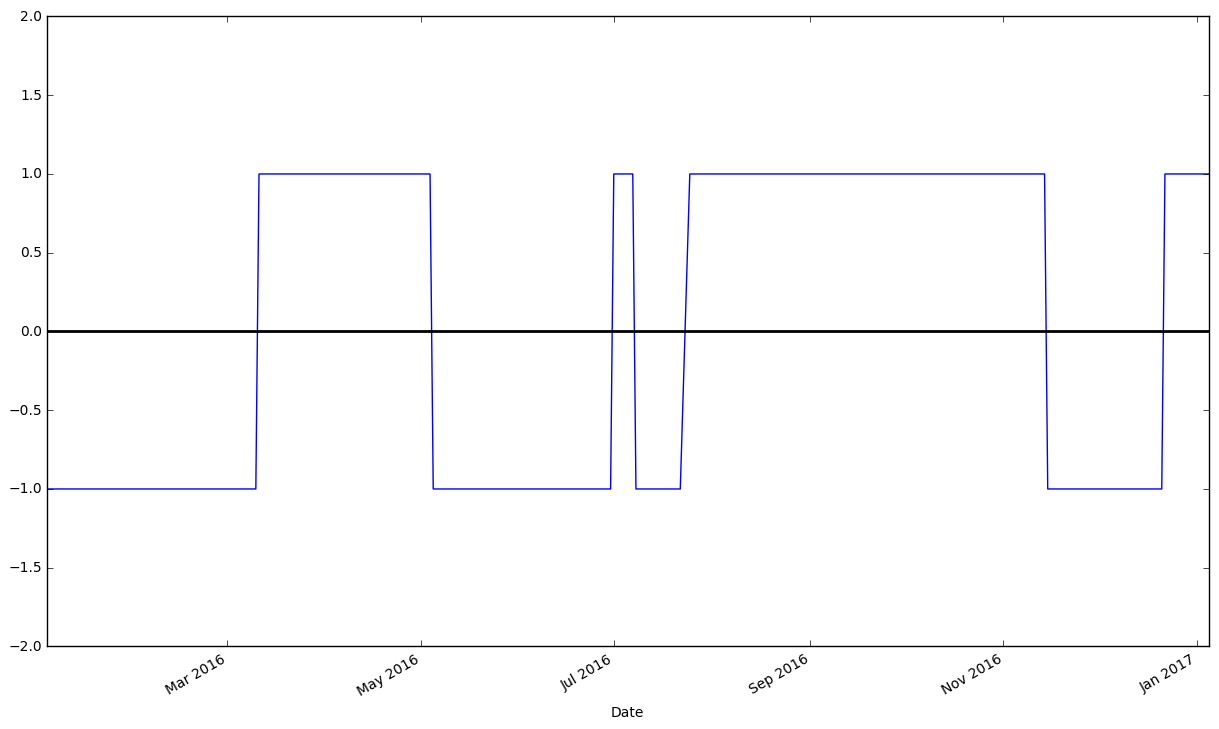

In [29]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np

import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9) 

start = datetime.datetime(2010,1,1)
end = datetime.date.today()

apple = web.DataReader("AAPL", "yahoo", start, end)
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])

apple.loc['2016-01-01':,"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)
# apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)


In [42]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

In [30]:
apple["Regime"].value_counts()

 1    1026
-1     689
 0      50
Name: Regime, dtype: int64

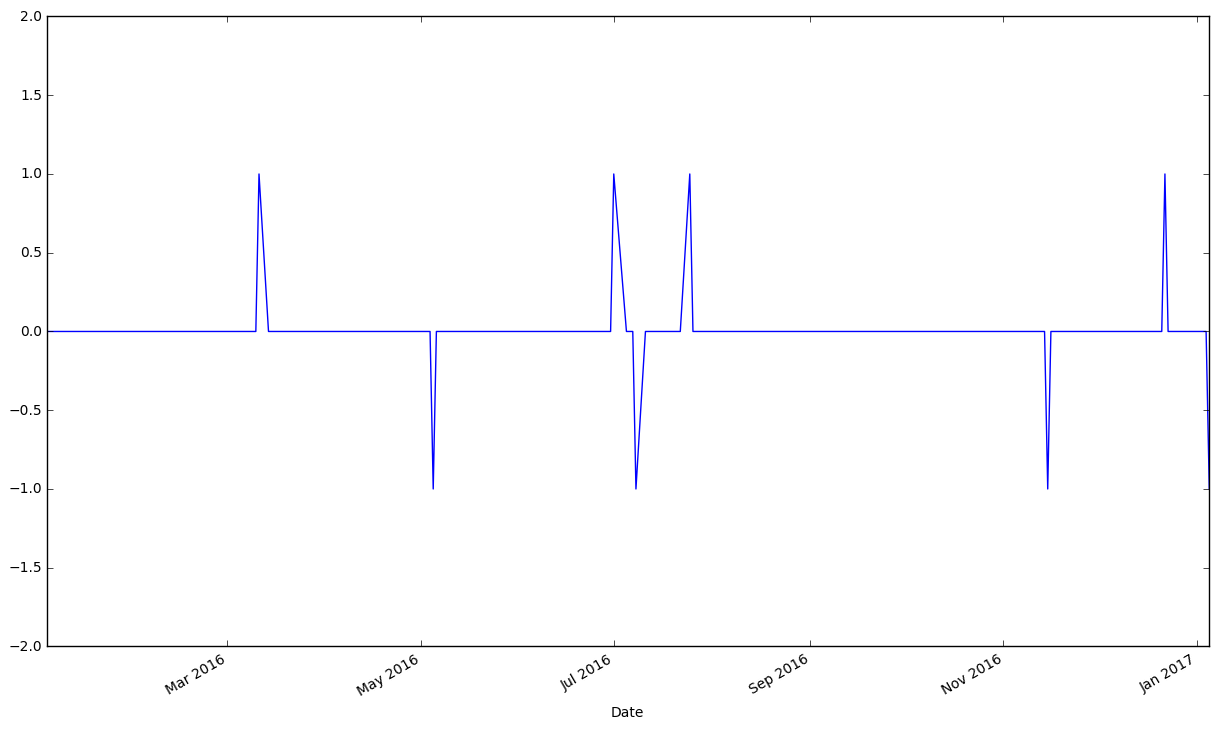

In [34]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.ix[-1, "Regime"]
apple.ix[-1, "Regime"] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.ix[-1, "Regime"] = regime_orig
apple.tail()
# apple["Signal"].plot(ylim = (-2, 2))
apple.loc['2016-01-01':,"Signal"].plot(ylim = (-2, 2))

In [36]:
apple["Signal"].value_counts()

 0.0    1721
-1.0      22
 1.0      21
Name: Signal, dtype: int64

In [37]:
# buy
apple.loc[apple["Signal"] == 1, "Close"]

Date
2010-03-16    224.449997
2010-06-18    274.070011
2010-09-20    283.230007
2011-05-12    346.569988
2011-07-14    357.770004
2011-12-28    402.640003
2012-06-25    570.770020
2013-05-17    433.260010
2013-07-31    452.529984
2013-10-16    501.110001
2014-03-26    539.779991
2014-04-25    571.939980
2014-08-18     99.160004
2014-10-28    106.739998
2015-02-05    119.940002
2015-04-28    130.559998
2015-10-27    114.550003
2016-03-11    102.260002
2016-07-01     95.889999
2016-07-25     97.339996
2016-12-22    116.290001
Name: Close, dtype: float64

In [38]:
# sell
apple.loc[apple["Signal"] == -1, "Close"]

Date
2010-06-11    253.509995
2010-07-22    259.020000
2011-03-30    348.630009
2011-03-31    348.510006
2011-05-27    337.409992
2011-11-17    377.410000
2012-05-09    569.180023
2012-10-17    644.610001
2013-06-26    398.069992
2013-10-03    483.409996
2014-01-28    506.499977
2014-04-22    531.700020
2014-06-11     93.860001
2014-10-17     97.669998
2015-01-05    106.250000
2015-04-16    126.169998
2015-06-25    127.500000
2015-12-18    106.029999
2016-05-05     93.239998
2016-07-08     96.680000
2016-11-15    107.110001
2017-01-05    116.610001
Name: Close, dtype: float64

In [39]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

,Price,Regime,Signal
Date,,,
2010-03-16,224.449997,1.0,Buy
2010-06-11,253.509995,-1.0,Sell
2010-06-18,274.070011,1.0,Buy
2010-07-22,259.020000,-1.0,Sell
2010-09-20,283.230007,1.0,Buy
2011-03-30,348.630009,0.0,Sell
2011-03-31,348.510006,-1.0,Sell
2011-05-12,346.569988,1.0,Buy
2011-05-27,337.409992,-1.0,Sell


In [40]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

,End Date,Price,Profit
Date,,,
2010-03-16,2010-06-11,224.449997,29.059998
2010-06-18,2010-07-22,274.070011,-15.050011
2010-09-20,2011-03-30,283.230007,65.400002
2011-05-12,2011-05-27,346.569988,-9.159996
2011-07-14,2011-11-17,357.770004,19.639996
2011-12-28,2012-05-09,402.640003,166.540020
2012-06-25,2012-10-17,570.770020,73.839981
2013-05-17,2013-06-26,433.260010,-35.190018
2013-07-31,2013-10-03,452.529984,30.880012


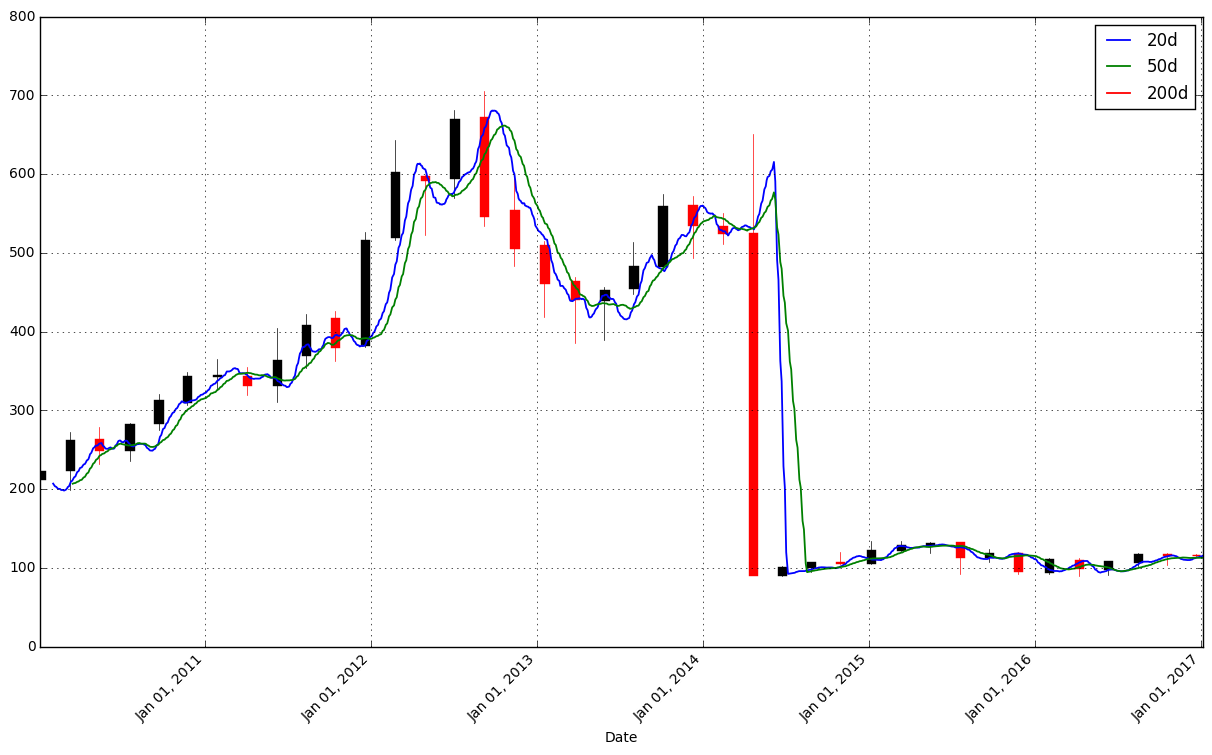

In [43]:
# Let's see the result over the whole period for which we have Apple data
pandas_candlestick_ohlc(apple, stick = 45, otherseries = ["20d", "50d", "200d"])

# Above, we can see that on May 17th, 2013, there was a massive drop in the price of Apple stock, 
# and it looks like our trading system would do badly. But this price drop is not because of a massive 
# shock to Apple, but simply due to a stock split. 

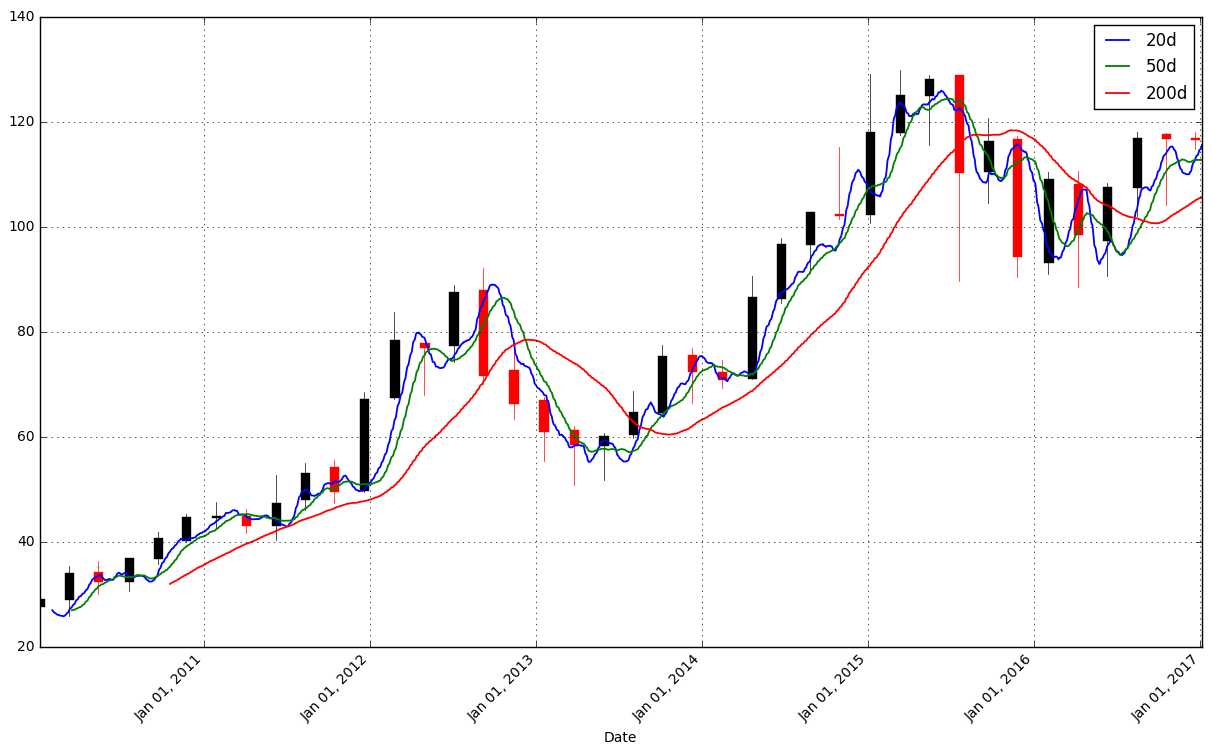

In [45]:
def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices
 
    :return: pandas DataFrame with adjusted stock data
 
    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Adj Close"] / dat["Close"],
                       "High": dat["High"] * dat["Adj Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Adj Close"] / dat["Close"],
                       "Close": dat["Adj Close"]})
 
apple_adj = ohlc_adj(apple)
 
# This next code repeats all the earlier analysis we did on the adjusted data
 
apple_adj["20d"] = np.round(apple_adj["Close"].rolling(window = 20, center = False).mean(), 2)
apple_adj["50d"] = np.round(apple_adj["Close"].rolling(window = 50, center = False).mean(), 2)
apple_adj["200d"] = np.round(apple_adj["Close"].rolling(window = 200, center = False).mean(), 2)
 
apple_adj['20d-50d'] = apple_adj['20d'] - apple_adj['50d']
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple_adj["Regime"] = np.where(apple_adj['20d-50d'] < 0, -1, apple_adj["Regime"])
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple_adj.ix[-1, "Regime"]
apple_adj.ix[-1, "Regime"] = 0
apple_adj["Signal"] = np.sign(apple_adj["Regime"] - apple_adj["Regime"].shift(1))
# Restore original regime data
apple_adj.ix[-1, "Regime"] = regime_orig
 
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_adj_signals = pd.concat([
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == 1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple_adj.loc[apple_adj["Signal"] == -1, "Close"],
                     "Regime": apple_adj.loc[apple_adj["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_adj_signals.sort_index(inplace = True)
apple_adj_long_profits = pd.DataFrame({
        "Price": apple_adj_signals.loc[(apple_adj_signals["Signal"] == "Buy") &
                                  apple_adj_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_adj_signals["Price"] - apple_adj_signals["Price"].shift(1)).loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_adj_signals["Price"].loc[
            apple_adj_signals.loc[(apple_adj_signals["Signal"].shift(1) == "Buy") & (apple_adj_signals["Regime"].shift(1) == 1)].index
        ].index
    })
 
pandas_candlestick_ohlc(apple_adj, stick = 45, otherseries = ["20d", "50d", "200d"])

In [46]:
apple_adj_long_profits

,End Date,Price,Profit
Date,,,
2010-03-16,2010-06-10,29.205718,3.390961
2010-06-18,2010-07-22,35.662337,-1.958327
2010-09-20,2011-03-30,36.854247,8.509931
2011-05-12,2011-05-27,45.096125,-1.191910
2011-07-14,2011-11-17,46.553486,2.555581
2011-12-28,2012-05-09,52.392027,21.670398
2012-06-25,2012-10-17,74.269317,9.968284
2013-05-17,2013-06-26,57.587132,-4.677312
2013-07-31,2013-10-04,60.148417,4.477846


In [47]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_adj_long_profits.index,
                            "End": apple_adj_long_profits["End Date"]})
apple_adj_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple_adj.loc[x["Start"]:x["End"], "Low"]), axis = 1)
apple_adj_long_profits

,End Date,Price,Profit,Low
Date,,,,
2010-03-16,2010-06-10,29.205718,3.390961,25.926661
2010-06-18,2010-07-22,35.662337,-1.958327,31.177056
2010-09-20,2011-03-30,36.854247,8.509931,35.783347
2011-05-12,2011-05-27,45.096125,-1.191910,42.864549
2011-07-14,2011-11-17,46.553486,2.555581,45.935408
2011-12-28,2012-05-09,52.392027,21.670398,52.114867
2012-06-25,2012-10-17,74.269317,9.968284,73.597889
2013-05-17,2013-06-26,57.587132,-4.677312,52.589494
2013-07-31,2013-10-04,60.148417,4.477846,59.736379


In [59]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 100000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .1    # % of trade loss that would trigger a stoploss
for index, row in apple_adj_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)
 
apple_backtest

,End Date,End Port. Value,Profit per Share,Share Price,Shares,Start Port. Value,Stop-Loss Triggered,Total Profit,Trade Value
2010-03-16,2010-06-10,107887.0000,26.290000,29.205718,300.0,100000.0000,1.0,7887.0000,8761.7154
2010-06-18,2010-07-22,117517.0000,32.100000,35.662337,300.0,107887.0000,1.0,9630.0000,10698.7011
2010-09-20,2011-03-30,120069.9793,8.509931,36.854247,300.0,117517.0000,0.0,2552.9793,11056.2741
2011-05-12,2011-05-27,119831.5973,-1.191910,45.096125,200.0,120069.9793,0.0,-238.3820,9019.2250
2011-07-14,2011-11-17,120342.7135,2.555581,46.553486,200.0,119831.5973,0.0,511.1162,9310.6972
2011-12-28,2012-05-09,124676.7931,21.670398,52.392027,200.0,120342.7135,0.0,4334.0796,10478.4054
2012-06-25,2012-10-17,125673.6215,9.968284,74.269317,100.0,124676.7931,0.0,996.8284,7426.9317
2013-05-17,2013-06-26,124738.1591,-4.677312,57.587132,200.0,125673.6215,0.0,-935.4624,11517.4264
2013-07-31,2013-10-04,125633.7283,4.477846,60.148417,200.0,124738.1591,0.0,895.5692,12029.6834
2013-10-16,2014-01-28,125745.4072,1.116789,67.045247,100.0,125633.7283,0.0,111.6789,6704.5247


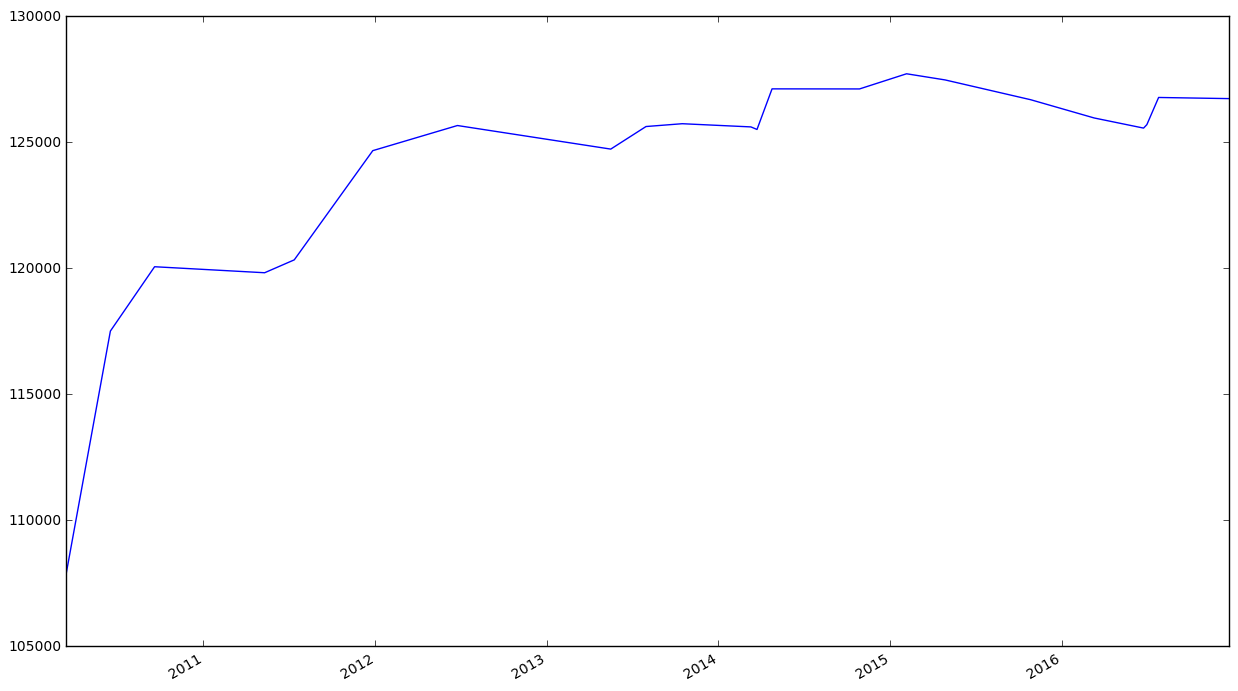

In [60]:
apple_backtest["End Port. Value"].plot()